In [1]:
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.visualization import LogStretch, ImageNormalize, AsymmetricPercentileInterval
import pfsspy

import sunpy.map
from sunpy.net import Fido,attrs as a
from sunpy.coordinates.sun import carrington_rotation_number
from sunpy.coordinates import propagate_with_solar_surface
from sunpy.coordinates.utils import solar_angle_equivalency
import sunpy.visualization.drawing

import synthesizAR
from synthesizAR.util import change_obstime, change_obstime_frame, from_pfsspy

from mocksipipeline.detector.response import Channel

# Build Magnetic Skeleton of AR

In [2]:
m_aia = sunpy.map.Map('../data/observations/ar_2020-11-09T18:00:00.000/AIA/aia_lev1_171a_2020_11_09t17_59_57_34z_image_lev1.fits')

Observatory,SDO
Instrument,AIA 3
Detector,AIA
Measurement,171.0 Angstrom
Wavelength,171.0 Angstrom
Observation Date,2020-11-09 17:59:57
Exposure Time,1.999558 s
Dimension,[4096. 4096.] pix
Coordinate System,helioprojective
Scale,[0.599489 0.599489] arcsec / pix
Reference Pixel,[2054.107178 2046.863037] pix

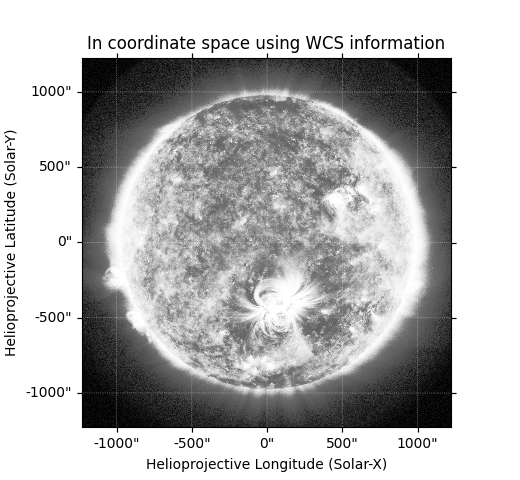
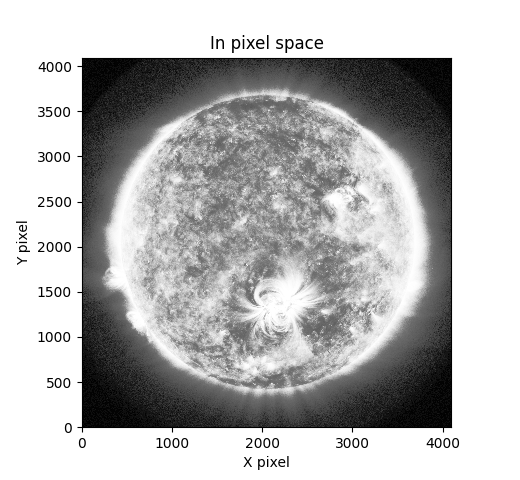
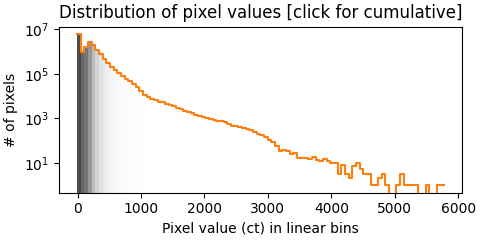
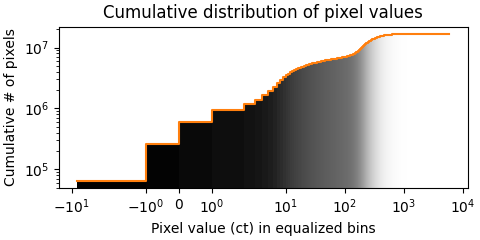

In [3]:
m_aia

In [35]:
m_aia.date.isot

'2020-11-09T17:59:57.340'

In [4]:
car_rot = carrington_rotation_number(m_aia.date)

In [5]:
q = Fido.search(
    a.Time('2010/01/01', '2010/01/01'),
    a.jsoc.Series('hmi.synoptic_mr_polfil_720s'),
    a.jsoc.PrimeKey('CAR_ROT', int(car_rot)),
    a.jsoc.Notify('will.t.barnes@gmail.com')
)

In [6]:
q

TELESCOP,INSTRUME,WAVELNTH,CAR_ROT
str7,str9,float64,int64
SDO/HMI,HMI_SIDE1,6173.0,2237


In [40]:
import pathlib

In [42]:
pathlib.Path(file[0])

PosixPath('../data/simulations/hmi.synoptic_mr_polfil_720s.2237.Mr_polfil.fits')

In [7]:
file = Fido.fetch(q, path='../data/simulations/')

Export request pending. [id=JSOC_20230612_1313_X_IN, status=2]
Waiting for 0 seconds...
1 URLs found for download. Full request totalling 4MB


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [8]:
m_hmi = sunpy.map.Map(file)

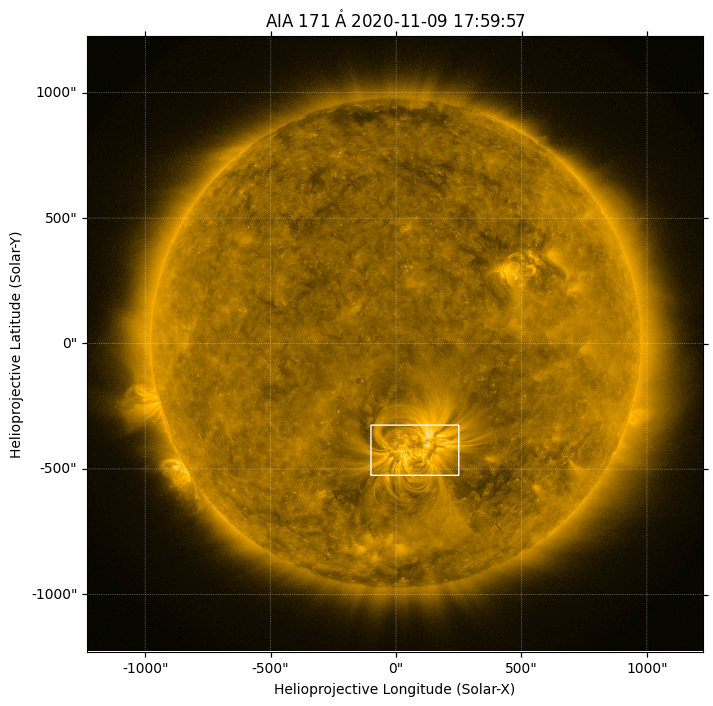

In [9]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,projection=m_aia)
m_aia.plot(axes=ax)
blc_ar = SkyCoord(Tx=-100*u.arcsec, Ty=-525*u.arcsec, frame=m_aia.coordinate_frame)
trc_ar = SkyCoord(Tx=250*u.arcsec, Ty=-325*u.arcsec, frame=m_aia.coordinate_frame)
m_aia.draw_quadrangle(blc_ar, top_right=trc_ar,axes=ax)

In [10]:
blc_ar_synop = change_obstime(blc_ar.transform_to(change_obstime_frame(m_hmi.coordinate_frame, blc_ar.obstime)), m_hmi.date)
trc_ar_synop = change_obstime(trc_ar.transform_to(change_obstime_frame(m_hmi.coordinate_frame, trc_ar.obstime)), m_hmi.date)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


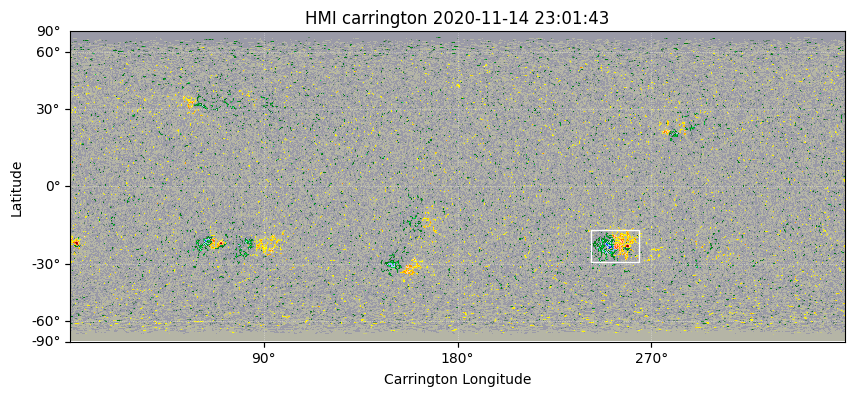

In [11]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(projection=m_hmi)
m_hmi.plot(axes=ax)
m_hmi.draw_quadrangle(blc_ar_synop, top_right=trc_ar_synop)

In [12]:
m_hmi_resample = m_hmi.resample((1080,540)*u.pix)

In [13]:
nrho = 70
rss = 2.5
pfss_input = pfsspy.Input(m_hmi_resample, nrho, rss, )

In [14]:
pfss_output = pfsspy.pfss(pfss_input)

In [15]:
# This searches the (non-integer) pixel coordinates
num_seeds = 3000
pix_blc = m_hmi_resample.wcs.world_to_pixel(blc_ar_synop)
pix_trc = m_hmi_resample.wcs.world_to_pixel(trc_ar_synop)
pixel_random = np.random.uniform(low=pix_blc, high=pix_trc, size=(num_seeds,2)).T
seeds = m_hmi_resample.wcs.pixel_to_world(*pixel_random).make_3d()

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


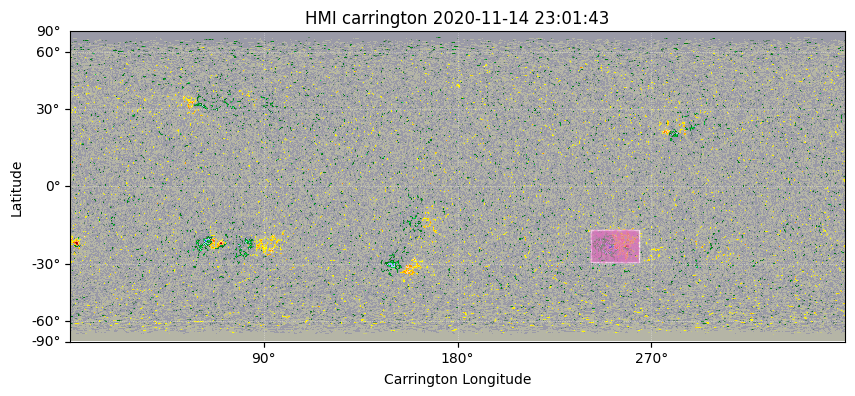

In [16]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(projection=m_hmi)
m_hmi.plot(axes=ax)
m_hmi.draw_quadrangle(blc_ar_synop, top_right=trc_ar_synop)
ax.plot_coord(seeds, marker='.', color='C6', ls='', markersize=1, alpha=0.2)

In [17]:
ds = 0.05
max_steps = int(np.ceil(2 * nrho / ds))
tracer = pfsspy.tracing.FortranTracer(step_size=ds, max_steps=max_steps)
fieldlines = tracer.trace(SkyCoord(seeds), pfss_output,)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/pfsspy/output.py:95: UserWarning: Could not parse unit string "Mx/cm^2" as a valid FITS unit.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards.
  warnings.warn(f'Could not parse unit string "{unit_str}" as a valid FITS unit.\n'
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 2800) and try again.
  warnings.warn(


In [18]:
strands = from_pfsspy(fieldlines.closed_field_lines,
                      n_min=100,
                      obstime=m_aia.date,
                      length_min=20*u.Mm,
                      length_max=400*u.Mm,
                      cross_sectional_area=1e16*u.cm**2)

In [19]:
len(strands)

1418

In [20]:
with propagate_with_solar_surface():
    strands = [synthesizAR.Loop(l.name,
                                l.coordinate.transform_to(m_aia.observer_coordinate.frame),
                                field_strength=l.field_strength,
                                cross_sectional_area=l.cross_sectional_area,) for l in strands]

Do some manual exclusion of structures that extend too far outside of the AR

In [21]:
strands_local = []
for s in strands:
    coord = s.coordinate.transform_to(m_aia.coordinate_frame)
    if np.any(coord.Ty>-250*u.arcsec):
        continue
    if np.any(coord.Ty<-600*u.arcsec):
        continue
    if np.any(coord.Tx>200*u.arcsec):
        continue
    if np.any(coord.Tx<-70*u.arcsec):
        continue
    strands_local.append(s)

(971.1716220925127, 1704.5929099778627)

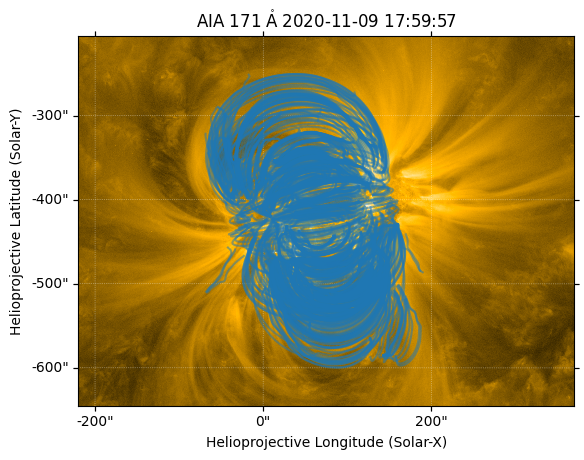

In [22]:
fig = plt.figure()
ax = fig.add_subplot(projection=m_aia)
m_aia.plot(axes=ax)
for s in strands_local:
    ax.plot_coord(s.coordinate, color='C0', alpha=0.5)
ax.set_xlim(m_aia.wcs.world_to_pixel(blc_ar)[0]-200, m_aia.wcs.world_to_pixel(trc_ar)[0]+200)
ax.set_ylim(m_aia.wcs.world_to_pixel(blc_ar)[1]-200, m_aia.wcs.world_to_pixel(trc_ar)[1]+200)

In [23]:
skeleton = synthesizAR.Skeleton(strands_local)

In [24]:
len(skeleton.loops)

879

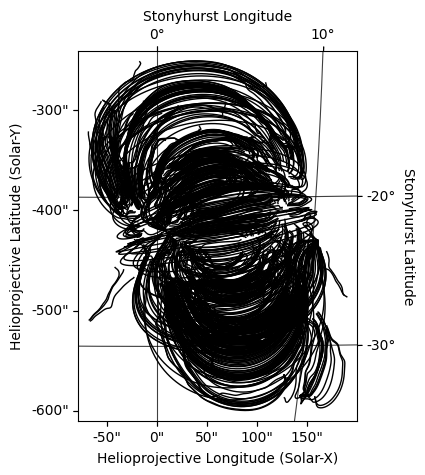

In [25]:
skeleton.peek(observer=m_aia.observer_coordinate)

(array([ 42., 223., 150., 109.,  70.,  38.,  41.,  54.,  31.,  32.,  16.,
         10.,   5.,   9.,  24.,  15.,  10.]),
 array([ 20.54170988,  42.86027013,  65.17883039,  87.49739065,
        109.81595091, 132.13451117, 154.45307143, 176.77163169,
        199.09019195, 221.40875221, 243.72731247, 266.04587273,
        288.36443299, 310.68299325, 333.0015535 , 355.32011376,
        377.63867402, 399.95723428]),
 [<matplotlib.patches.Polygon at 0x340439400>])

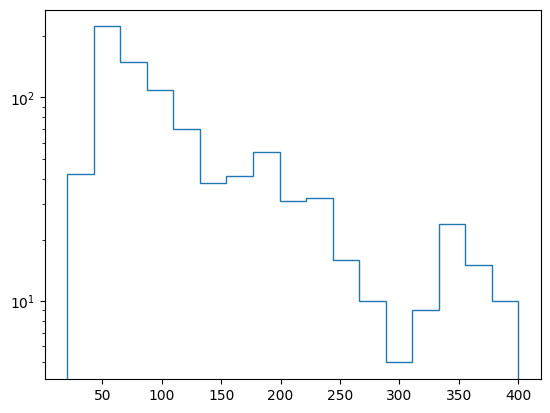

In [26]:
plt.hist([s.length.to_value('Mm') for s in skeleton.loops], histtype='step', bins='fd', log=True)

Finally, we'll reinterplate each strand to a resolution appropriate to the instrument modeling we'll be doing later.

In [27]:
chan = Channel('filtergram_1')
angular_res = chan.resolution[0]
delta_angle = angular_res / 2 * u.pix
delta_s = delta_angle.to(
    u.Mm,
    equivalencies=solar_angle_equivalency(skeleton.loops[0].coordinate.observer)
)

INFO: Apparent body location accounts for 493.60 seconds of light travel time [sunpy.coordinates.ephemeris]


In [28]:
delta_s

<Quantity 2.65446389 Mm>

In [29]:
skeleton_coarse = skeleton.refine_loops(delta_s, prepkwargs={'k': 1})

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:300: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


Make sure that everything still looks ok after downsampling

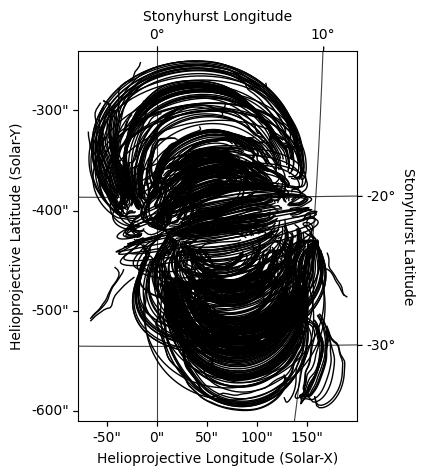

In [31]:
skeleton_coarse.peek(observer=m_aia.observer_coordinate,)

In [32]:
skeleton_coarse.to_asdf('../data/simulations/skeleton.asdf')

In [44]:
m_aia.bottom_left_coord.Tx - m_aia.top_right_coord.Tx

<Angle -2454.04873423 arcsec>